In [2]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
import pandas as pd

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1): #subclustering
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data) # estandariza los valores, los pone entre 0 y 1
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata) # la distancia de cada punto de una matriz con cada punto de la otra, en resumen devuelve una matriz
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0) #esto es el array de potenciales
   
    centers = []
    i=np.argmax(P) # le paso el potencial maximo (indice en realidad)
    C = ndata[i] #ahora si le paso el maximo
    p=P[i] # para luego la resta en el recalculo de potenciales
    centers = [C] #le asigno al centro
    
    #LO QUE VIENE ACÁ ES EL RECALCULO, NO LE VOY A DAR MUCHA PELOTA
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers #RETORNA LOS CENTROS DE CLUSTER, Y LABELS (A QUE CLUSTER PERTENECE)

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = subclust2(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

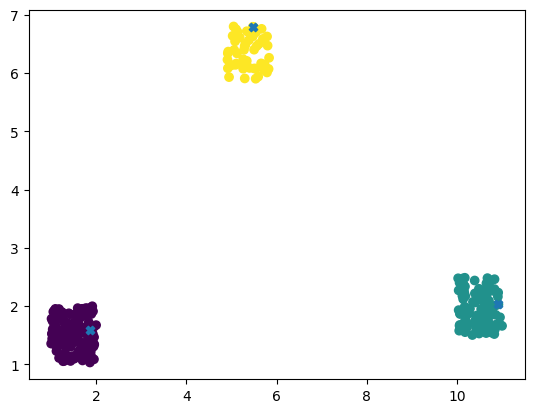

In [10]:
c1 = np.random.rand(150,2)+[1,1]
c2 = np.random.rand(100,2)+[10,1.5] #devuelve 100 filas y 2 columnas entre 0 y 1, a la columna 1 le suma 10 y a la 2 1.5, esto por cada fila
c3 = np.random.rand(50,2)+[4.9,5.8]
m = np.append(c1,c2, axis=0)
m = np.append(m,c3, axis=0)
#concatena los nparray
r,c = subclust2(m,1) #callea el subclustering con los datos y el Ra, retorna los labels de los clusters, y la posicion de los centros de clusters

plt.figure()
plt.scatter(m[:,0],m[:,1], c=r) #grafica los datos
plt.scatter(c[:,0],c[:,1], marker='X') #grafica los centros de cluster con una cruz

# GEN Fis
## Generación de FIS a partir de agrupamiento de los datos de entrenamiento

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5 #ecuacion de las diap
            y = gaussmf(x,m,s) #arma la gaussiana con los datos, la media y el sigma de la ecuacion
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii):      #ACA INICIA EL METODO

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii) #ACA APLICA EL SUSTRACTIVO Y SE TRAE LA MAT DE LABEL Y LOS CDK
        
        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
    
        
        nivel_acti = np.array(f).T
        print("nivel acti")
        print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1)) # apila los array con la sumatorias
        print("sumMu")
        print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()

# Test genfis 1 entrada

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272.]
--- 0.009000778198242188 seconds ---
nivel acti
[[0.2254097  0.90062053 0.01831564 0.98625451 0.63279266 0.98263523
  0.98945906]
 [0.23359831 0.90903474 0.01942115 0.98945906 0.64536933 0.98625451
  0.99224476]
 [0.24197971 0.91713079 0.02058448 0.99224476 0.65791133 0.98945906
  0.99460801]
 [0.250553

array([-2.93574153e+06, -4.94865240e+09, -6.23500269e+04, -4.21686476e+09,
       -5.15916894e+07, -4.20159210e+09,  2.34712992e+09,  1.63052900e+09,
       -1.72305048e+08,  3.88890998e+07, -5.40673570e+09,  2.61714829e+10,
        3.12417179e+09, -4.22956261e+09])

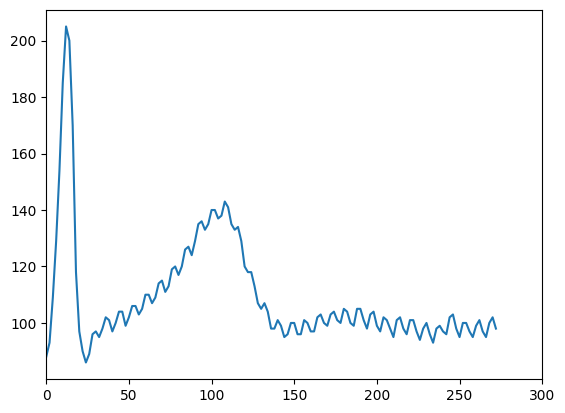

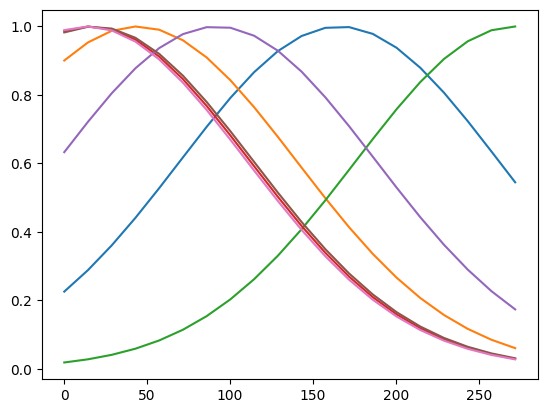

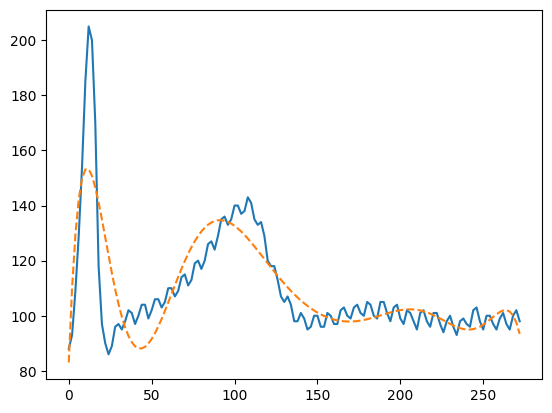

In [31]:
#test genfis 1D
import pandas as pd
def my_exponential(A, B, C, x):
    return A*np.exp(-B*x)+C

#data_x = np.arange(-10,10,0.1)
#data_y = -0.5*data_x**3-0.6*data_x**2+10*data_x+1 #my_exponential(9, 0.5,1, data_x)
df = pd.read_csv("E:\Valum\Escritorio\Python VSC\Sugeno\samplesVDA2.txt",header=None)
data_y = np.array([])
for i in df.values.tolist():
    data_y = np.append(data_y,i[0]) #copia los valores del txt en el arreglo y

data_x = np.array([])
x=0
for i in range(len(data_y)):
    data_x=np.append(data_x,x*2) #aca es medio ficticio lo que metio MR. CV que básicamente es ir agregando el dominio valores de x para que de la imagen de la cosa arterial en y
    x+=1

print(data_x)
plt.plot(data_x, data_y)
# plt.ylim(-20,20)
plt.xlim(0,300)

data = np.vstack((data_x, data_y)).T

fis2 = fis()
fis2.genfis(data, 0.7)
fis2.viewInputs()
r = fis2.evalfis(np.vstack(data_x))

plt.figure()
plt.plot(data_x,data_y)
plt.plot(data_x,r,linestyle='--')

fis2.solutions

# r1 = data_x*-2.29539539+ -41.21850973
# r2 = data_x*-15.47376916 -79.82911266
# r3 = data_x*-15.47376916 -79.82911266
# plt.plot(data_x,r1)
# plt.plot(data_x,r2)
# plt.plot(data_x,r3)

# Test genfis 2 entradas

--- 0.31307077407836914 seconds ---
[-7.07106781 -7.07106781]
nivel acti
[[3.38618175e-01 5.41007741e-03 3.81216813e-02 9.02055516e-02
  9.91704735e-01]
 [3.60147666e-01 6.10971052e-03 4.40675107e-02 9.00553967e-02
  9.96673600e-01]
 [3.81771846e-01 6.87686887e-03 5.07712605e-02 8.96064301e-02
  9.98335414e-01]
 ...
 [4.91893422e-02 7.80180556e-01 3.91515003e-02 2.06154197e-02
  7.37684005e-04]
 [4.47332264e-02 7.53357552e-01 3.86975750e-02 1.75977656e-02
  6.33913213e-04]
 [4.05454743e-02 7.25036925e-01 3.81216813e-02 1.49718625e-02
  5.42927945e-04]]
sumMu
[[1.46406022]
 [1.49705388]
 [1.52736182]
 ...
 [0.8898745 ]
 [0.85502003]
 [0.81921887]]
[  5.86288805   9.25873343 -37.29981739  -1.39631292  -5.76847075
 -80.12603747  11.52297151 -11.43525169 180.45790836 -10.69454417
 -12.33979411   5.48324203  13.69722831   6.93651714 114.99860553]


C:\Users\usuario\AppData\Local\Temp\ipykernel_16532\1078960879.py:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


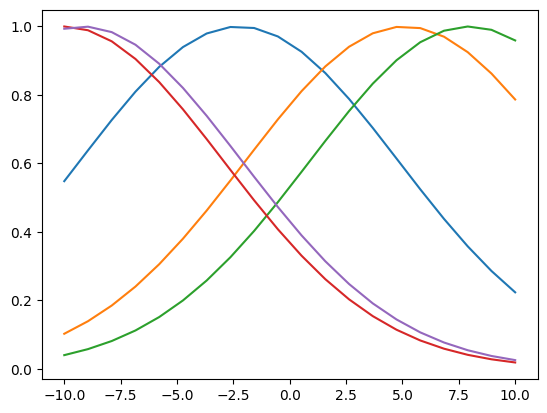

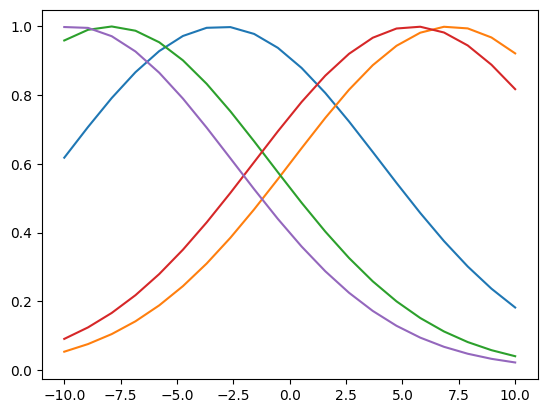

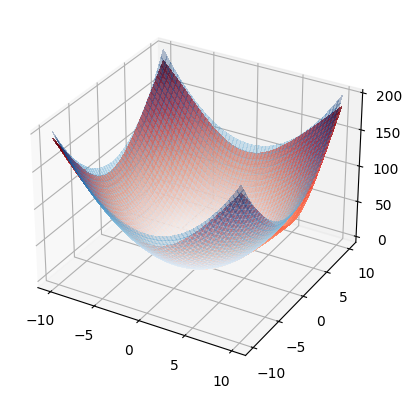

In [17]:
from matplotlib import cm

x=np.linspace(-10,10,50)
X,Y = np.meshgrid(x,x)
Z = X**2+Y**2

data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

fis = fis()
fis.genfis(data,1.2)
fis.viewInputs()

r = fis.evalfis(np.vstack((X.ravel(), Y.ravel())).T)
r = np.reshape(r, X.shape)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,Z, cmap=cm.Blues,
                        linewidth=0, antialiased=False, alpha=0.3)

surf = ax.plot_surface(X,Y, r, cmap=cm.Reds,
                        linewidth=0, antialiased=False, alpha=0.8)
